#### Google Login

In [ ]:
%%capture
from glob import glob
from tqdm.notebook import tqdm
import random
import polars as pl
import json
pl.Config.set_fmt_str_lengths(100)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
DATASETS = "/content/drive/MyDrive/datasets/UKR_TEB"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Training data prep

In [ ]:
!mkdir $DATASETS

In [ ]:
# ukr OpenSubtitles, 877,780 sentence pairs
!curl https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-uk.txt.zip \
     --output OPUS-OpenSubtitles.txt.zip
!unzip OPUS-OpenSubtitles.txt.zip -d OPUS-OpenSubtitles/

# Wikimedia, 757,910 sentences
!curl https://object.pouta.csc.fi/OPUS-wikimedia/v20230407/moses/en-uk.txt.zip \
     --output wikimedia.txt.zip
!unzip wikimedia.txt.zip -d wikimedia/

# SciPar_Ukraine, 306,813 sentences
!curl https://object.pouta.csc.fi/OPUS-ELRC-5183-SciPar_Ukraine/v1/moses/en-uk.txt.zip\
     --output SciPar_Ukraine.txt.zip
!unzip SciPar_Ukraine.txt.zip -d SciPar_Ukraine/

# QED, 215,530 sentence pairs
!curl https://object.pouta.csc.fi/OPUS-QED/v2.0a/moses/en-uk.txt.zip \
     --output OPUS-QED.txt.zip
!unzip OPUS-QED.txt.zip -d OPUS-QED/

# TED2020, 208,141 sentences
!curl https://object.pouta.csc.fi/OPUS-TED2020/v1/moses/en-uk.txt.zip \
     --output OPUS-TED2020.txt.zip
!unzip OPUS-TED2020.txt.zip -d OPUS-TED2020/

# ukr Tatoeba, 175,502 sentence pairs
!curl https://object.pouta.csc.fi/OPUS-Tatoeba/v2023-04-12/moses/en-uk.txt.zip \
     --output OPUS-Tatoeba.txt.zip
!unzip OPUS-Tatoeba.txt.zip -d OPUS-Tatoeba/


# ELRC-5179-acts_Ukrainian
!curl https://object.pouta.csc.fi/OPUS-ELRC-5179-acts_Ukrainian/v1/moses/en-uk.txt.zip \
     --output OPUS-ELRC-5179-acts_Ukrainian.txt.zip
!unzip OPUS-ELRC-5179-acts_Ukrainian.txt.zip -d OPUS-ELRC-5179-acts_Ukrainian/


# ELRC-5180-Official_Parliament_Ukraine_Ukrainian_laws_EN
!curl https://object.pouta.csc.fi/OPUS-ELRC-5180-Official_Parliament_/v1/moses/en-uk.txt.zip \
     --output OPUS-ELRC-5180-Official_Parliament_.txt.zip
!unzip OPUS-ELRC-5180-Official_Parliament_.txt.zip -d OPUS-ELRC-5180-Official_Parliament_/


# ELRC-5181-Official_Parliament_Ukraine_abstracts_UK_laws
!curl https://object.pouta.csc.fi/OPUS-ELRC-5181-Official_Parliament_/v1/moses/en-uk.txt.zip \
     --output OPUS-ELRC-5181-Official_Parliament_.txt.zip
!unzip OPUS-ELRC-5181-Official_Parliament_.txt.zip -d OPUS-ELRC-5181-Official_Parliament_/


# ELRC-5174-French_Polish_Ukrain
!curl https://object.pouta.csc.fi/OPUS-ELRC-5174-French_Polish_Ukrain/v1/moses/en-uk.txt.zip/v1/moses/en-uk.txt.zip \
     --output OPUS-ELRC-5174-French_Polish_Ukrain.txt.zip
!unzip OPUS-ELRC-5174-French_Polish_Ukrain.txt.zip -d OPUS-ELRC-5174-French_Polish_Ukrain/

# Dataset compiling

#### FastText installation

In [ ]:
! pip install fasttext
! wget "https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin" lid.176.bin

import fasttext
path_to_pretrained_model = 'lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 932.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4227134 sha256=d816f9c3150b813aff71fbc471e91ca05b29a99cfd980d59806dcca569a145c9
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext
--2024-04-28 17:04:42--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.51, 3.162.163.19, 3.162.163.34, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M   205MB/s    in 0.6s    

2024-04-28 17:0

#### Parsing function

In [ ]:
def parse(folder, output_name):
    source_lines, target_lines = [], []

    for folder in tqdm(glob(f"{folder}*")):

        for file in glob(f"{folder}/*"):
            if file.endswith(".en"):
                with open(file) as f:
                    for line in f:
                        source_lines.append(line.strip())
            elif file.endswith(".uk"):
                with open(file) as f:
                    for line in f:
                        target_lines.append(line.strip())
    df = pl.DataFrame({
        "eng": source_lines,
        "ukr": target_lines
    })

    print(f"ORIGINAL: {df.shape[0]:_}")
    df = df.unique(maintain_order=False)
    print(f"UNIQUE: {df.shape[0]:_}")

    texts = (
    df.select('ukr')
        .with_columns(
            pl.col('ukr').str.to_lowercase()
        )
    )['ukr'].to_list()
    predictions = fmodel.predict(texts)[0]

    predictions = [el[0][-2:] for el in predictions]

    df = (
        df
        .with_columns(
            pl.Series(name="lang", values=predictions)
        )
    )

    df = (
        df
        .filter(
            (pl.col('lang') == "uk") |
            (pl.col('ukr').str.to_lowercase().str.contains("ї")) |
            (pl.col('ukr').str.to_lowercase().str.contains("і"))
        )
    )
    print(f"UKR: {df.shape[0]:_}")

    df = (
        df
        .with_columns([
            pl.col('eng').str.split(" ").list.len().alias('source_len'),
            pl.col('ukr').str.split(" ").list.len().alias('target_len')
        ])
        .with_columns(
            (pl.col('target_len') / pl.col('source_len')).alias('num_times')
        )
    )

    df = (
        df
        .filter(
            (pl.col('num_times') < 3) & (pl.col('num_times') > 0.3)
        )
    )
    print(f"FILTERING LENS: {df.shape[0]:_}")


    df[['eng', 'ukr']].write_parquet(f"{DATASETS}/{output_name}.parquet")

### OpenSubtitles

In [ ]:
parse(folder="OPUS-Open", output_name="opensubtitles")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 877_780
UNIQUE: 783_651
UKR: 432_426
FILTERING LENS: 421_082


### Wikimedia

In [ ]:
parse(folder="OPUS-wiki", output_name="wikimedia")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 757_910
UNIQUE: 711_823
UKR: 639_124
FILTERING LENS: 627_576


### SciPar

In [ ]:
parse(folder="OPUS-SciPar", output_name="SciPar")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 306_813
UNIQUE: 306_813
UKR: 306_811
FILTERING LENS: 306_316


### QED

In [ ]:
parse(folder="OPUS-QE", output_name="QED")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 215_630
UNIQUE: 206_928
UKR: 202_426
FILTERING LENS: 199_931


### Tatoeba

In [ ]:
parse(folder="OPUS-Tatoeba", output_name="tatoeba")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 175_502
UNIQUE: 175_488
UKR: 171_456
FILTERING LENS: 171_329


### TED2020

In [ ]:
parse(folder="OPUS-TED", output_name="TED2020")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 208_141
UNIQUE: 202_866
UKR: 201_407
FILTERING LENS: 200_591


### ELRC

In [ ]:
parse(folder="OPUS-ELRC", output_name="OPUS-ELRC")

  0%|          | 0/8 [00:00<?, ?it/s]

ORIGINAL: 343_442
UNIQUE: 342_913
UKR: 337_829
FILTERING LENS: 337_515


In [ ]:
parse(folder="OPUS-ELRC-5179", output_name="OPUS-ELRC-5179")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 129_942
UNIQUE: 129_942
UKR: 126_361
FILTERING LENS: 126_273


NameError: name 'DATASETS' is not defined

In [ ]:
parse(folder="OPUS-ELRC-5180", output_name="OPUS-ELRC-5180")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 116_260
UNIQUE: 116_260
UKR: 115_494
FILTERING LENS: 115_475


NameError: name 'DATASETS' is not defined

In [ ]:
parse(folder="OPUS-ELRC-5181", output_name="OPUS-ELRC-5181")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 61_012
UNIQUE: 61_012
UKR: 60_885
FILTERING LENS: 60_861


NameError: name 'DATASETS' is not defined

In [ ]:
parse(folder="OPUS-ELRC-5174", output_name="OPUS-ELRC-5174")

  0%|          | 0/2 [00:00<?, ?it/s]

ORIGINAL: 36_228
UNIQUE: 36_214
UKR: 35_597
FILTERING LENS: 35_414


NameError: name 'DATASETS' is not defined

# Combine and dedup

In [ ]:
!rm {DATASETS}/comb_training_dataset.parquet

rm: cannot remove '/content/drive/MyDrive/datasets/UKR_MTEB/comb_training_dataset.parquet': No such file or directory


In [ ]:
df = pl.read_parquet(f"{DATASETS}/*.parquet")

In [ ]:
print(f"{df.shape[0]:_}")

df = df.unique(maintain_order=False)

print(f"{df.shape[0]:_}")

2_264_340
2_202_117


In [ ]:
df.sample(5)

eng,ukr
str,str
"""Another assault the following morning was met with equally fierce resistance by the Portuguese.""","""Атака наступного ранку зустріла не менш запеклий опір з боку португальці ."""
"""Since the quality of the analysis results mainly depends on the quality of the input image, researc…","""Так як якість результатів аналізу здебільшого залежить від якості вхідного зображення, дослідникам …"
"""In the last decades several countries have tied state funding of political parties to compliance wi…","""В останні десятиліття кілька країн прив’язали державне фінансування політичних партій до дотримання…"
"""He later researched the prehistory of Scandinavia.""","""Пізніше він дослідив доісторичну Скандинавію ."""
"""I questioned the Tatar chambermaid.""","""Я розпитав служницю-татарку."""


In [ ]:
for _ in range(10):
    df = df.sample(fraction=1, shuffle=True)

In [ ]:
df.write_parquet(
    f"{DATASETS}/comb_training_dataset.parquet"
)

# Training the model

In [ ]:
%%capture
!pip install -U sentence-transformers

Cloning into 'sentence-transformers'...
remote: Enumerating objects: 8915, done.
remote: Counting objects: 100% (297/297), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 8915 (delta 143), reused 212 (delta 92), pack-reused 8618
Receiving objects: 100% (8915/8915), 17.87 MiB | 7.18 MiB/s, done.
Resolving deltas: 100% (6155/6155), done.
/content/sentence-transformers


In [ ]:
from sentence_transformers import (
    SentenceTransformer, LoggingHandler, models, evaluation, losses
)

from torch.utils.data import DataLoader

from datetime import datetime
from sentence_transformers.util import cos_sim
import os
import logging
import sentence_transformers.util
import csv
from tqdm.autonotebook import tqdm
import numpy as np
import io

import torch
from torch import nn, Tensor
from typing import Iterable, Dict

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class TranslationCosSimLoss(nn.Module):
    def __init__(self, model: SentenceTransformer,
                 loss_fct=nn.MSELoss(),
                 cos_score_transformation=nn.Identity()):

        super(TranslationCosSimLoss, self).__init__()
        self.model = model
        self.loss_fct = loss_fct
        self.cos_score_transformation = cos_score_transformation

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # labels == target embeddings
        student_model_rep = self.model(sentence_features[0])["sentence_embedding"]
        output = self.cos_score_transformation(
            torch.cosine_similarity(student_model_rep, labels)
        )
        # print(f"{output = }")
        loss = self.loss_fct(
            output,
            torch.ones(len(student_model_rep), dtype=torch.float32, device=device)
        )
        # print(f"{loss = }")
        return loss

In [ ]:
df = pl.read_parquet(
    f"{DATASETS}/comb_training_dataset.parquet"
)

In [ ]:
logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%Y-%m-%d %H:%M:%S", level=logging.INFO, handlers=[LoggingHandler()]
)
logger = logging.getLogger(__name__)

In [ ]:
from torch.utils.data import Dataset
import logging
import gzip
from sentence_transformers.readers import InputExample
from typing import List
import random


logger = logging.getLogger(__name__)


class ParallelSentencesDataset(Dataset):
    """
    This dataset reader can be used to read-in parallel sentences, i.e., it reads in a file with tab-seperated sentences with the same
    sentence in different languages. For example, the file can look like this (EN\tDE\tES):
    hello world     hallo welt  hola mundo
    second sentence zweiter satz    segunda oración

    The sentence in the first column will be mapped to a sentence embedding using the given the embedder. For example,
    embedder is a mono-lingual sentence embedding method for English. The sentences in the other languages will also be
    mapped to this English sentence embedding.

    When getting a sample from the dataset, we get one sentence with the according sentence embedding for this sentence.

    teacher_model can be any class that implement an encode function. The encode function gets a list of sentences and
    returns a list of sentence embeddings
    """

    def __init__(
        self,
        student_model: SentenceTransformer,
        teacher_model: SentenceTransformer,
        batch_size: int = 8,
        use_embedding_cache: bool = True,
    ):
        """
        Parallel sentences dataset reader to train student model given a teacher model

        :param student_model: Student sentence embedding model that should be trained
        :param teacher_model: Teacher model, that provides the sentence embeddings for the first column in the dataset file
        """
        self.student_model = student_model
        self.teacher_model = teacher_model
        self.datasets = []
        self.datasets_iterator = []
        self.datasets_tokenized = []
        self.dataset_indices = []
        self.copy_dataset_indices = []
        self.cache = []
        self.batch_size = batch_size
        self.use_embedding_cache = use_embedding_cache
        self.embedding_cache = {}
        self.num_sentences = 0

    def load_data(self, filepath: str, weight: int = 100, max_sentences: int = None, max_sentence_length: int = 128):
        """
        Reads in a tab-seperated .txt/.csv/.tsv or .gz file. The different columns contain the different translations of the sentence in the first column

        :param filepath: Filepath to the file
        :param weight: If more than one dataset is loaded with load_data: With which frequency should data be sampled from this dataset?
        :param max_sentences: Max number of lines to be read from filepath
        :param max_sentence_length: Skip the example if one of the sentences is has more characters than max_sentence_length
        :param batch_size: Size for encoding parallel sentences
        :return:
        """

        logger.info("Load " + filepath)
        parallel_sentences = []

        with gzip.open(filepath, "rt", encoding="utf8") if filepath.endswith(".gz") else open(
            filepath, encoding="utf8"
        ) as fIn:
            count = 0
            for line in fIn:
                sentences = line.strip().split("\t")
                if (
                    max_sentence_length is not None
                    and max_sentence_length > 0
                    and max([len(sent) for sent in sentences]) > max_sentence_length
                ):
                    continue

                parallel_sentences.append(sentences)
                count += 1
                if max_sentences is not None and max_sentences > 0 and count >= max_sentences:
                    break
        self.add_dataset(
            parallel_sentences, weight=weight, max_sentences=max_sentences, max_sentence_length=max_sentence_length
        )

    def add_dataset(
        self,
        parallel_sentences: List[List[str]],
        weight: int = 100,
        max_sentences: int = None,
        max_sentence_length: int = 128,
    ):
        sentences_map = {}
        for sentences in parallel_sentences:
            if (
                max_sentence_length is not None
                and max_sentence_length > 0
                and max([len(sent) for sent in sentences]) > max_sentence_length
            ):
                continue

            source_sentence = sentences[0]
            if source_sentence not in sentences_map:
                sentences_map[source_sentence] = set()

            for sent in sentences:
                sentences_map[source_sentence].add(sent)

            if max_sentences is not None and max_sentences > 0 and len(sentences_map) >= max_sentences:
                break

        if len(sentences_map) == 0:
            return

        self.num_sentences += sum([len(sentences_map[sent]) for sent in sentences_map])

        dataset_id = len(self.datasets)
        self.datasets.append(list(sentences_map.items()))
        self.datasets_iterator.append(0)
        self.dataset_indices.extend([dataset_id] * weight)

    def generate_data(self):
        source_sentences_list = []
        target_sentences_list = []
        for data_idx in self.dataset_indices:
            src_sentence, trg_sentences = self.next_entry(data_idx)
            source_sentences_list.append(src_sentence)
            target_sentences_list.append(trg_sentences)

        # Generate embeddings
        src_embeddings = self.get_embeddings(source_sentences_list)

        for src_embedding, trg_sentences in zip(src_embeddings, target_sentences_list):
            for trg_sentence in trg_sentences:
                self.cache.append(InputExample(texts=[trg_sentence], label=src_embedding))

        random.shuffle(self.cache)

    def next_entry(self, data_idx):
        source, target_sentences = self.datasets[data_idx][self.datasets_iterator[data_idx]]

        self.datasets_iterator[data_idx] += 1
        if self.datasets_iterator[data_idx] >= len(self.datasets[data_idx]):  # Restart iterator
            self.datasets_iterator[data_idx] = 0
            random.shuffle(self.datasets[data_idx])

        return source, target_sentences

    def get_embeddings(self, sentences):
        if not self.use_embedding_cache:
            return self.teacher_model.encode(
                sentences, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True
            )

        # Use caching
        new_sentences = []
        for sent in sentences:
            if sent not in self.embedding_cache:
                new_sentences.append(sent)

        if len(new_sentences) > 0:
            new_embeddings = self.teacher_model.encode(
                new_sentences, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True
            )
            for sent, embedding in zip(new_sentences, new_embeddings):
                self.embedding_cache[sent] = embedding

        return [self.embedding_cache[sent] for sent in sentences]

    def __len__(self):
        return self.num_sentences

    def __getitem__(self, idx):
        if len(self.cache) == 0:
            self.generate_data()

        return self.cache.pop()

In [ ]:
teacher_model_original = SentenceTransformer(
    'sentence-transformers/all-mpnet-base-v2', trust_remote_code=True
)

teacher_model = SentenceTransformer(
    modules=[teacher_model_original[0], teacher_model_original[1]]
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
max_seq_length = 128  # Student model max. lengths for inputs (number of word pieces)
train_batch_size = 48  # Batch size for training
inference_batch_size = 128  # Batch size at inference
train_max_sentence_length = 512  # Maximum length (characters) for parallel training sentences

num_epochs = 1  # Train for x epochs
num_dev_sentences = 5_000

num_train_sentences = len(df) - num_dev_sentences

In [ ]:
student_model_name = "youscan/ukr-roberta-base"

word_embedding_model = models.Transformer(
    student_model_name,
    max_seq_length=max_seq_length
)
# Apply mean pooling to get one fixed sized sentence vector
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension()
)
student_model = SentenceTransformer(
    modules=[word_embedding_model, pooling_model],
    device=device
)

In [ ]:
df[:num_train_sentences].write_csv("train.csv", separator="\t")

In [ ]:
num_warmup_steps = num_train_sentences / train_batch_size // 20  # Warumup steps

num_evaluation_steps = num_train_sentences / train_batch_size // 10  # Evaluate performance after every xxxx steps

In [ ]:
###### Read Parallel Sentences Dataset ######
train_data = ParallelSentencesDataset(
    student_model=student_model,
    teacher_model=teacher_model,
    batch_size=inference_batch_size,
    use_embedding_cache=True
)
for train_file in ["train.csv"]:
    train_data.load_data(
        train_file, max_sentence_length=train_max_sentence_length
    )

In [ ]:
train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=train_batch_size
)
train_loss = TranslationCosSimLoss(model=student_model)
# train_loss = losses.MSELoss(model=student_model) #

In [ ]:
# num_dev_sentences = 1_000
src_sentences = df[
    num_train_sentences:num_train_sentences+num_dev_sentences
]['eng'].to_list()
trg_sentences = df[
    num_train_sentences:num_train_sentences+num_dev_sentences
]['ukr'].to_list()
print(f"{len(src_sentences):_}")

evaluators = []
# Mean Squared Error (MSE) measures the (euclidean) distance between teacher and student embeddings
dev_mse = evaluation.MSEEvaluator(
    src_sentences,
    trg_sentences,
    teacher_model=teacher_model,
    batch_size=inference_batch_size,
    # write_csv=False
)
evaluators.append(dev_mse)

5_000


In [ ]:
# Train the model
student_model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluation.SequentialEvaluator(evaluators, main_score_function=lambda scores: np.mean(scores)),
    epochs=num_epochs,
    warmup_steps=0, # num_warmup_steps
    evaluation_steps=num_evaluation_steps,
    output_path="trained_en_uk_1M",
    save_best_model=True,
    optimizer_params={"lr": 2e-5, "eps": 1e-6},
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/120640 [00:00<?, ?it/s]

In [ ]:
from huggingface_hub import login

login(HF_TOKEN) # please use your own

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
student_model.push_to_hub(
    "maiia-bocharova/ukr_sentence_transformer",
    private=True
)

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

'https://huggingface.co/Maiia/ukr_sentence_transformer/commit/62a56ba53cdfb43ff11da4d7b3bf30f31138367f'

In [ ]:
df.sample(5)

eng,ukr
str,str
"""In such a manner, they caused it to stop and turn at bay.""","""Таким чином вони змушували його зупинитися і повернути на відстань."""
"""List of dates, showing the type of show, attendance and revenue earned Date Type of show Attendance…","""Список дат, що показують тип шоу, відвідування та дохід Дата Тип шоу Відвідуваність / Місткість Дох…"
"""You'll die in jail.""","""Ви помрете у в'язниці."""
"""I get a bit depressed sometimes.""","""Інколи находить депресія."""
"""So then, once you've done that, the next stage is to know what it is.""","""Наступне завдання - дізнатись, що ж це таке."""


In [ ]:
df[-500:].sample(5)

eng,ukr
str,str
"""She's made of painted oak, between the years of about 1500-1530, this one made probably in Brussels…","""Вона зроблена з розмальованого дуба між 1500 та 1530 роками, ймовірно, у Брюсселі або на півдні Нід…"
"""This was due to the exclusion of anyone who had died following restraint but had not at that point …","""Причиною стало виключення кожного, хто помер після затримання, але на той час не був офіційно зааре…"
"""It was only after the Spanish transition to democracy that the tradition was restored to the Basque…","""Лише після переходу Іспанії до демократії ця традиція в Країні Басків була відновлена."""
"""Please watch this movie.""","""Будь ласка, подивись цей фільм."""
"""I'm still responsible for Tom.""","""Я все ще відповідаю за Тома."""


In [ ]:
print(f"""{cos_sim(
   student_model.encode("Я хочу купити собі щось їстівне"),
   student_model.encode("На вулиці дощ"),
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{cos_sim(
    teacher_model.encode("Cats can see in the dark."),
    student_model.encode("Коти можуть бачити у темряві.")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{cos_sim(
    teacher_model.encode("Her book from 1938 on the subject, Structural Petrography, brought her much distinction."),
    student_model.encode("Її книга 1938 року присвячена цій темі «Структурна петрографія» принесла їй велику популярність.")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{cos_sim(
    student_model.encode("Я голодна"),
    student_model.encode("Я хочу їсти")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{cos_sim(
    student_model.encode("На вулиці дощ"),
    student_model.encode("Накрапує дощик")
) = }""", end=("\n" + "="*50 + "\n"))


print(f"""{
    cos_sim(
    teacher_model.encode("I want to eat!"),
    student_model.encode("Її книга 1938 року присвячена цій темі «Структурна петрографія» принесла їй велику популярність.")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{
    cos_sim(
    student_model.encode("Дивитися фільми - це круто!"),
    student_model.encode("Я хочу переглянути кіно")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{
    cos_sim(
    teacher_model.encode("So a bunch of the subject pairs, they play face to face."),
    student_model.encode("Є кілька пар суб'єктів, які грають обличчям до обличчя.")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{
    cos_sim(
    teacher_model.encode("So a bunch of the subject pairs, they play face to face."),
    student_model.encode("Розкрито основні принципи економічної політики Європейського Союзу.")
) = }""", end=("\n" + "="*50 + "\n"))

print(f"""{
    cos_sim(
    teacher_model.encode("So a bunch of the subject pairs, they play face to face."),
    student_model.encode("Розкрито основні принципи економічної політики Європейського Союзу.")
) = }""", end=("\n" + "="*50 + "\n"))

cos_sim(
   student_model.encode("Я хочу купити собі щось їстівне"),
   student_model.encode("На вулиці дощ"),
) = tensor([[0.0899]])
cos_sim(
    teacher_model.encode("Cats can see in the dark."),
    student_model.encode("Коти можуть бачити у темряві.")
) = tensor([[0.7705]])
cos_sim(
    teacher_model.encode("Her book from 1938 on the subject, Structural Petrography, brought her much distinction."),
    student_model.encode("Її книга 1938 року присвячена цій темі «Структурна петрографія» принесла їй велику популярність.")
) = tensor([[0.6538]])
cos_sim(
    student_model.encode("Я голодна"),
    student_model.encode("Я хочу їсти")
) = tensor([[0.9258]])
cos_sim(
    student_model.encode("На вулиці дощ"),
    student_model.encode("Накрапує дощик")
) = tensor([[0.4031]])

    cos_sim(
    teacher_model.encode("I want to eat!"),
    student_model.encode("Її книга 1938 року присвячена цій темі «Структурна петрографія» принесла їй велику популярність.")
) = tensor([[0.0756]])

    cos_si

# Custom Training (Used in the paper)

In [ ]:
"maiia-bocharova/ukr_sentence_pairs_mpnet" -> "sentence-transformers/all-mpnet-base-v2"
"maiia-bocharova/ukr_sentence_pairs_e5" -> "intfloat/e5-base-v2"
"maiia-bocharova/ukr_sentence_pairs_bge" -> "BAAI/bge-base-en-v1.5"
"maiia-bocharova/ukr_sentence_pairs_gte" -> "Alibaba-NLP/gte-base-en-v1.5"

##### Printer

In [ ]:
import IPython.display as disp

def text_to_html_table(items):
    "Put the texts in `items` in an HTML table."
    html_code = """<table border="1" class="dataframe">\n"""
    html_code += """  <thead>\n <tr style="text-align: left;">\n"""
    for i in items[0]:
        html_code += f"      <th>{i}</th>\n"
    html_code += "    </tr>\n  </thead>\n  <tbody>\n"
    for line in items[1:]:
        html_code += "    <tr>\n"
        for elt in line:
            elt = f"{elt:.6f}" if isinstance(elt, float) else str(elt)
            html_code += f"      <td>{elt}</td>\n"
        html_code += "    </tr>\n"
    html_code += "  </tbody>\n</table><p>"
    return html_code

#### Installs

In [ ]:
%%capture
!pip install datasets

In [ ]:
from huggingface_hub import login
login(HF_TOKEN)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
import datasets
from transformers import (
    get_scheduler,
    AutoTokenizer, AutoModel,
    DataCollatorForLanguageModeling
)
from transformers.trainer_pt_utils import LengthGroupedSampler
from torch.optim import AdamW
import torch
from typing import List, Optional, Tuple, Union, Any, Dict
from dataclasses import dataclass

from torch.utils.data import DataLoader
import numpy as np
# from sentence_transformers import SentenceTransformer
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
MAX_LEN = 256
NUM_DEV = 5_000
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 128
EPOCHS = 2

#### Load models and tokenizer

In [ ]:
teacher_checkpoint = 'sentence-transformers/all-mpnet-base-v2'
# teacher_checkpoint = "Alibaba-NLP/gte-base-en-v1.5"
student_checkpoint = "youscan/ukr-roberta-base"

tokenizer_target = AutoTokenizer.from_pretrained(student_checkpoint)
tokenizer_source = AutoTokenizer.from_pretrained(teacher_checkpoint)

teacher_model = AutoModel.from_pretrained(
    teacher_checkpoint,
    trust_remote_code=True
).to(device)
student_model = AutoModel.from_pretrained(
    student_checkpoint
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.86M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output #First element of model_output contains all token embeddings
    input_mask_expanded = (
        attention_mask
        .unsqueeze(-1)
        .expand(token_embeddings.size())
        .float()
    )
    return (
        torch.sum(token_embeddings * input_mask_expanded, 1) /
        torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    )

#### Read data

In [ ]:
dataset = datasets.load_dataset("maiia-bocharova/ukr_sentence_pairs_mpnet")

Generating train split:   0%|          | 0/2197117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
tokenizer_target.decode(dataset['train'][1_100]['input_ids'])

"Комбіновані заявки, такі як стратегія, що базується на опціонах, поновлення ф'ючерсних контрактів тощо"

In [ ]:
tokenizer_source.decode(dataset['train'][1_100]['source_input_ids'])

"combined orders such as options'strategy, futures'roll, etc. )"

In [ ]:
# dataset['train'][900]['input_ids']

#### Create dataset and tokenize

In [ ]:
df = pl.read_parquet(
    f"{DATASETS}/comb_training_dataset.parquet"
)
print(f"{df.shape[0]:_}")

2_202_117


In [ ]:
features = datasets.Features({
        'sent_source': datasets.Value('string'),
        'sent_target': datasets.Value('string'),
    })

dataset = datasets.DatasetDict({
    "train": datasets.Dataset.from_dict({
        'sent_source': df['eng'][:len(df)-NUM_DEV].to_list(),
        'sent_target': df['ukr'][:len(df)-NUM_DEV].to_list(),
    }, features=features),
    "test": datasets.Dataset.from_dict({
        'sent_source': df['eng'][-NUM_DEV:].to_list(),
        'sent_target': df['ukr'][-NUM_DEV:].to_list(),
    }, features=features)
})

In [ ]:
tokenizer_target = AutoTokenizer.from_pretrained(
    "youscan/ukr-roberta-base"
)

tokenizer_source = AutoTokenizer.from_pretrained(
    "Alibaba-NLP/gte-base-en-v1.5"
)

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    target_sent_ids = tokenizer_target(
        batch['sent_target'],
        truncation=True,
        max_length=MAX_LEN,
        add_special_tokens=False
    )['input_ids']
    source_sent_ids = tokenizer_source(
        batch['sent_source'],
        truncation=True,
        max_length=MAX_LEN,
        add_special_tokens=False
    )['input_ids']
    batch['input_ids'] = target_sent_ids
    batch['source_input_ids'] = source_sent_ids
    return batch

dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/2197117 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
dataset.push_to_hub("Maiia/ukr_sentence_pairs_gte", private=True)

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Maiia/ukr_sentence_pairs_gte/commit/6b13b35fd99e08ea416745831ed28cd0b8723fcd', commit_message='Upload dataset', commit_description='', oid='6b13b35fd99e08ea416745831ed28cd0b8723fcd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
dataset.push_to_hub("Maiia/ukr_sentence_pairs_mpnet", private=True)

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Creating parquet from Arrow format:   0%|          | 0/733 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/Maiia/ukr_sentence_pairs_mpnet/commit/15ff4452a1555c5fbca45101d188546bc7abf199', commit_message='Upload dataset', commit_description='', oid='15ff4452a1555c5fbca45101d188546bc7abf199', pr_url=None, pr_revision=None, pr_num=None)

#### Data Collator

In [ ]:
@dataclass
class DataCollatorForSentenceEmbedder(DataCollatorForLanguageModeling):

    def torch_call(self, examples):

        target_input_ids = [e["input_ids"] for e in examples]
        source_input_ids = [e["source_input_ids"] for e in examples]

        (
            source_input_ids, target_input_ids,
            attention_source_mask, attention_target_mask
        ) = self._torch_collate_batch(
                      target_input_ids, source_input_ids
                  )
        return {
            "target_input_ids": target_input_ids[:, :MAX_LEN],
            "source_input_ids": source_input_ids[:, :MAX_LEN],
            "source_attention_mask": attention_source_mask[:, :MAX_LEN],
            "target_attention_mask": attention_target_mask[:, :MAX_LEN],
        }


    def _torch_collate_batch(self, target_input_ids, source_input_ids,
                             pad_to_multiple_of: Optional[int] = None):
        """Collate `examples` into a batch, using the information in `tokenizer` for padding if necessary."""

        # Tensorize if necessary.
        if isinstance(target_input_ids[0], (list, tuple, np.ndarray)):
            target_input_ids = [torch.tensor(e, dtype=torch.long) for e in target_input_ids]
            source_input_ids = [torch.tensor(e, dtype=torch.long) for e in source_input_ids]

        max_length_source = max(x.size(0) for x in source_input_ids)
        max_length_target = max(x.size(0) for x in target_input_ids)

        attention_source_mask = source_input_ids[0].new_full(
                [len(source_input_ids), max_length_source],
                0
            )
        attention_target_mask = target_input_ids[0].new_full(
                [len(target_input_ids), max_length_target],
                0
            )
        result_source_input_ids = source_input_ids[0].new_full(
                [len(source_input_ids), max_length_source],
                tokenizer_source.pad_token_id
            )
        result_target_input_ids = target_input_ids[0].new_full(
                [len(target_input_ids), max_length_target],
                tokenizer_target.pad_token_id
            )
        for i, example in enumerate(source_input_ids):
            result_source_input_ids[i, :example.shape[0]] = example
            attention_source_mask[i, :example.shape[0]] = torch.ones(len(example))

            result_target_input_ids[i, :target_input_ids[i].shape[0]] = target_input_ids[i]
            attention_target_mask[i, :target_input_ids[i].shape[0]] = torch.ones(len(target_input_ids[i]))
        return (
            result_source_input_ids, result_target_input_ids,
            attention_source_mask, attention_target_mask
        )

#### Initialize data loader

In [ ]:
data_collator = DataCollatorForSentenceEmbedder(tokenizer=tokenizer_target)

train_sampler = LengthGroupedSampler(
                        dataset=dataset['train'],
                        batch_size=TRAIN_BATCH_SIZE
                )

test_sampler = LengthGroupedSampler(
                        dataset=dataset['test'],
                        batch_size=TEST_BATCH_SIZE
              )
train_dataloader = DataLoader(
    dataset['train'],
    collate_fn=data_collator,
    sampler=train_sampler,
    batch_size=TRAIN_BATCH_SIZE
)

eval_dataloader = DataLoader(
    dataset['test'],
    collate_fn=data_collator,
    sampler=test_sampler,
    batch_size=TEST_BATCH_SIZE
)

### Train Loop

In [ ]:
loss_history = []
dev_recall_history = []
optimizer = AdamW(student_model.parameters(), lr=2e-5)
total_steps = len(dataset['train']) * EPOCHS // TRAIN_BATCH_SIZE
eval_steps = total_steps // 10
warmup_steps = total_steps // 20

loss_fn = torch.nn.MSELoss()
lr_scheduler = get_scheduler(
                    "linear",
                    optimizer=optimizer,
                    num_warmup_steps=warmup_steps,
                    num_training_steps=total_steps
                )

#### Cos sim

In [ ]:
student_model.train()
teacher_model.eval()
print_items = [['Step', 'Train', 'Val']]
output = None
i = 0

train_metrics, test_metrics = [], []
progress_bar = tqdm(range(len(train_dataloader) * 2))
for epoch in range(EPOCHS):
    loss_history = []
    for batch in train_dataloader:
        progress_bar.update(1)
        target_attention_mask = batch['target_attention_mask'].to(device)
        source_attention_mask = batch['source_attention_mask'].to(device)
        target_embeds = student_model(
                batch['target_input_ids'].to(device),
                attention_mask=target_attention_mask.to(device)
            ).last_hidden_state
        with torch.no_grad():
            source_embeds = teacher_model(
                batch['source_input_ids'].to(device),
                attention_mask=source_attention_mask.to(device)
            ).last_hidden_state
        pooled_target = mean_pooling(target_embeds, target_attention_mask)
        pooled_source = mean_pooling(source_embeds, source_attention_mask)
        cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
        target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
        loss = loss_fn(cos_sim_val, target)
        loss_history.append(float(loss))
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        i += 1
        if i % eval_steps == 0:
            train_score = sum(loss_history) / eval_steps
            loss_history = []
            train_metrics.append(train_score)
            student_model.eval()
            test_loss_history = []
            with torch.no_grad():
                for batch in eval_dataloader:
                    target_attention_mask = batch['target_attention_mask'].to(device)
                    source_attention_mask = batch['source_attention_mask'].to(device)
                    target_embeds = student_model(
                        batch['target_input_ids'].to(device),
                        attention_mask=target_attention_mask.to(device)
                    ).last_hidden_state

                    source_embeds = teacher_model(
                        batch['source_input_ids'].to(device),
                        attention_mask=source_attention_mask.to(device)
                    ).last_hidden_state
                    pooled_target = mean_pooling(target_embeds, target_attention_mask)
                    pooled_source = mean_pooling(source_embeds, source_attention_mask)
                    cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
                    target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
                    loss = loss_fn(cos_sim_val, target)

                    test_loss_history.append(float(loss))

            test_score = sum(test_loss_history) / len(test_loss_history)
            test_metrics.append(test_score)
            # print evals
            print_items.append([
                i, train_score, test_score
            ])
            html_code = text_to_html_table(print_items)
            if output is None:
                output = disp.display(disp.HTML(html_code), display_id=True)
            else:
                output.update(disp.HTML(html_code))
            student_model.train()

  0%|          | 0/137320 [00:00<?, ?it/s]

Step,Train,Val
13731,0.307803,0.191058
27462,0.179626,0.156801
41193,0.156699,0.140958
54924,0.144529,0.130159
68655,0.136713,0.124393
82386,0.125671,0.122238
96117,0.122166,0.119015
109848,0.119158,0.116429
123579,0.116993,0.113088
137310,0.115831,0.111492


In [ ]:
save_path = "maiia-bocharova/ukr_sentence_mpnet_cos_sim_2_epochs"
student_model.push_to_hub(
    save_path,
    private=True
)
tokenizer_target.push_to_hub(
    save_path,
    private=True
)
from datetime import date
print(f"{date.today() = }")

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

date.today() = datetime.date(2024, 5, 12)


#### MSE

In [ ]:
student_model.train()
teacher_model.eval()
print_items = [['Step', 'Train', 'Val']]
output = None
i = 0
eval_steps = len(train_dataloader) // 10
train_metrics, test_metrics = [], []

for batch in tqdm(train_dataloader):
    target_attention_mask = batch['target_attention_mask'].to(device)
    source_attention_mask = batch['source_attention_mask'].to(device)
    target_embeds = student_model(
            batch['target_input_ids'].to(device),
            attention_mask=target_attention_mask.to(device)
        ).last_hidden_state
    with torch.no_grad():
        source_embeds = teacher_model(
            batch['source_input_ids'].to(device),
            attention_mask=source_attention_mask.to(device)
        ).last_hidden_state
    pooled_target = mean_pooling(target_embeds, target_attention_mask)
    pooled_source = mean_pooling(source_embeds, source_attention_mask)
    # cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
    # target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
    loss = loss_fn(pooled_target, pooled_source)
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    i += 1
    if i % eval_steps == 0:
        train_score = sum(loss_history[-eval_steps:]) / eval_steps
        train_metrics.append(train_score)
        student_model.eval()
        test_loss_history = []
        with torch.no_grad():
            for batch in eval_dataloader:
                target_attention_mask = batch['target_attention_mask'].to(device)
                source_attention_mask = batch['source_attention_mask'].to(device)
                target_embeds = student_model(
                    batch['target_input_ids'].to(device),
                    attention_mask=target_attention_mask.to(device)
                ).last_hidden_state

                source_embeds = teacher_model(
                    batch['source_input_ids'].to(device),
                    attention_mask=source_attention_mask.to(device)
                ).last_hidden_state
                pooled_target = mean_pooling(target_embeds, target_attention_mask)
                pooled_source = mean_pooling(source_embeds, source_attention_mask)
                # cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
                # target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
                loss = loss_fn(pooled_target, pooled_source)

                test_loss_history.append(float(loss))

        test_score = sum(test_loss_history) / len(test_loss_history)
        test_metrics.append(test_score)
        # print evals
        print_items.append([
            i, train_score, test_score
        ])
        html_code = text_to_html_table(print_items)
        if output is None:
            output = disp.display(disp.HTML(html_code), display_id=True)
        else:
            output.update(disp.HTML(html_code))
        student_model.train()

  0%|          | 0/68660 [00:00<?, ?it/s]

Step,Train,Val
6866,0.256543,0.261078
13732,0.256341,0.262853
20598,0.256455,0.261122
27464,0.256558,0.262233
34330,0.256638,0.261158
41196,0.256814,0.261265
48062,0.256532,0.262262
54928,0.256523,0.261201
61794,0.256638,0.261717
68660,0.256777,0.259470


In [ ]:
save_path = "maiia-bocharova/ukr_sentence_mpnet_mse"
student_model.push_to_hub(
    save_path,
    private=True
)
tokenizer_target.push_to_hub(
    save_path,
    private=True
)

from datetime import date
print(f"{date.today() = }")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

date.today() = datetime.date(2024, 5, 10)


#### Comb

In [ ]:
student_model.train()
teacher_model.eval()
print_items = [['Step', 'Train', 'Val']]
output = None
i = 0
eval_steps = len(train_dataloader) // 10
train_metrics, test_metrics = [], []

for batch in tqdm(train_dataloader):
    target_attention_mask = batch['target_attention_mask'].to(device)
    source_attention_mask = batch['source_attention_mask'].to(device)
    target_embeds = student_model(
            batch['target_input_ids'].to(device),
            attention_mask=target_attention_mask.to(device)
        ).last_hidden_state
    with torch.no_grad():
        source_embeds = teacher_model(
            batch['source_input_ids'].to(device),
            attention_mask=source_attention_mask.to(device)
        ).last_hidden_state
    pooled_target = mean_pooling(target_embeds, target_attention_mask)
    pooled_source = mean_pooling(source_embeds, source_attention_mask)
    cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
    target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
    loss1 = loss_fn(pooled_target, pooled_source)
    loss2 = loss_fn(cos_sim_val, target)
    loss = loss1+loss2
    loss_history.append(float(loss))
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()

    i += 1
    if i % eval_steps == 0:
        train_score = sum(loss_history[-eval_steps:]) / eval_steps
        train_metrics.append(train_score)
        student_model.eval()
        test_loss_history = []
        with torch.no_grad():
            for batch in eval_dataloader:
                target_attention_mask = batch['target_attention_mask'].to(device)
                source_attention_mask = batch['source_attention_mask'].to(device)
                target_embeds = student_model(
                    batch['target_input_ids'].to(device),
                    attention_mask=target_attention_mask.to(device)
                ).last_hidden_state

                source_embeds = teacher_model(
                    batch['source_input_ids'].to(device),
                    attention_mask=source_attention_mask.to(device)
                ).last_hidden_state
                pooled_target = mean_pooling(target_embeds, target_attention_mask)
                pooled_source = mean_pooling(source_embeds, source_attention_mask)
                cos_sim_val = torch.cosine_similarity(pooled_target, pooled_source)
                target = torch.ones(len(cos_sim_val), dtype=torch.float32, device=device)
                loss1 = loss_fn(pooled_target, pooled_source)
                loss2 = loss_fn(cos_sim_val, target)
                loss = loss1+loss2
                test_loss_history.append(float(loss))

        test_score = sum(test_loss_history) / len(test_loss_history)
        test_metrics.append(test_score)
        # print evals
        print_items.append([
            i, train_score, test_score
        ])
        html_code = text_to_html_table(print_items)
        if output is None:
            output = disp.display(disp.HTML(html_code), display_id=True)
        else:
            output.update(disp.HTML(html_code))
        student_model.train()

  0%|          | 0/68660 [00:00<?, ?it/s]

Step,Train,Val
6866,0.624670,0.517716
13732,0.501117,0.486202
20598,0.479947,0.470665
27464,0.467517,0.460401
34330,0.460964,0.455866
41196,0.455934,0.451025
48062,0.451329,0.447328
54928,0.447560,0.443049
61794,0.445194,0.441523


Step,Train,Val
6866,0.624670,0.517716
13732,0.501117,0.486202
20598,0.479947,0.470665
27464,0.467517,0.460401
34330,0.460964,0.455866
41196,0.455934,0.451025
48062,0.451329,0.447328
54928,0.447560,0.443049
61794,0.445194,0.441523
68660,0.443779,0.440760


In [ ]:
student_model.push_to_hub(
    "maiia-bocharova/ukr_sentence_gte_mse_cos",
    private=True
)

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Maiia/ukr_sentence_gte_mse_cos/commit/53e21726df582769789672a4d016eb1bd0dcff7c', commit_message='Upload model', commit_description='', oid='53e21726df582769789672a4d016eb1bd0dcff7c', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer_target.push_to_hub(
    "maiia-bocharova/ukr_sentence_gte_mse_cos",
    private=True
)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Maiia/ukr_sentence_gte_mse_cos/commit/73042200eec21a6ff0027b352765bca3bfa42637', commit_message='Upload tokenizer', commit_description='', oid='73042200eec21a6ff0027b352765bca3bfa42637', pr_url=None, pr_revision=None, pr_num=None)

### Save to Hub

In [ ]:
# student_model.push_to_hub(
#     "maiia-bocharova//ukr_sentence_gte_cos_sim",
#     private=True
# )
tokenizer_target.push_to_hub(
    "maiia-bocharova//ukr_sentence_gte_cos_sim",
    private=True
)

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Maiia/ukr_sentence_gte_cos_sim/commit/634ad5ca565b53da19a336208158fb244b2bdcc7', commit_message='Upload tokenizer', commit_description='', oid='634ad5ca565b53da19a336208158fb244b2bdcc7', pr_url=None, pr_revision=None, pr_num=None)

# Cummulative distributions of similarities visualization

In [ ]:
%%capture
!pip install sentence-transformers

/content/sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sentence_transformers.util import cos_sim
import matplotlib.pyplot as plt

In [ ]:
df = pl.scan_parquet(
    f"{DATASETS}/comb_training_dataset.parquet"
).fetch(5_000)

In [ ]:
teacher_checkpoints = [
    'sentence-transformers/all-mpnet-base-v2',
    "Alibaba-NLP/gte-base-en-v1.5",
    "intfloat/e5-base-v2",
    "BAAI/bge-base-en-v1.5"
]
result = []
for teacher_checkpoint in teacher_checkpoints:
    model = SentenceTransformer(teacher_checkpoint,trust_remote_code=True)
    texts = df['eng'].to_list()

    embs = model.encode(
        texts,
        show_progress_bar=True,
        convert_to_tensor='pt'
    )
    sims = cos_sim(embs, embs).flatten().to("cpu").numpy()
    ind = np.argpartition(
        sims,
        -5_000
    )[:-5_000]
    print(teacher_checkpoint, round(np.percentile(sims[ind], 90), 2))
    hist = np.histogram(sims[ind], bins=10)
    result.append(hist)

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

sentence-transformers/all-mpnet-base-v2 0.16


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

Alibaba-NLP/gte-base-en-v1.5 0.31


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

intfloat/e5-base-v2 0.75


Batches:   0%|          | 0/157 [00:00<?, ?it/s]

BAAI/bge-base-en-v1.5 0.48


In [ ]:
hist

(array([    5246,   533560,  6516736, 12224594,  4972438,   688458,
           49720,     3800,      388,       60]),
 array([0.06774304, 0.16096862, 0.2541942 , 0.34741977, 0.44064534,
        0.53387094, 0.6270965 , 0.7203221 , 0.8135477 , 0.9067732 ,
        0.9999988 ], dtype=float32))

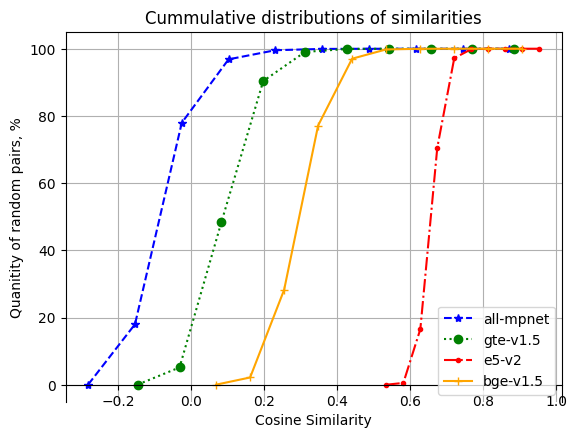

In [ ]:
# Plot the histogram
import matplotlib.ticker as mtick

colors = ["blue", "green", "red", "orange"]
markers = ["*", "o", ".", "+"]
linestyles = ["--", ":", "-.", "-"]
names = ["all-mpnet", "gte-v1.5", "e5-v2", "bge-v1.5"]
# Create a plot
fig, ax = plt.subplots()
for hist, name, color, marker, linestyle in zip(
                                                result,
                                                names,
                                                colors,
                                                markers,
                                                linestyles
                                              ):
    ax.plot(
        # x           y
        hist[1][:-1], (hist[0] / sum(hist[0])).cumsum() * 100,
        color=color,
        marker=marker,  # Optional: Add markers for each data point
        linestyle=linestyle,  # Optional: Change line style
        label=name
    )


plt.gca().set(
    title='Cummulative distributions of similarities',
    ylabel='Quanitity of random pairs, %',
    xlabel="Cosine Similarity"
)
# Set the position of the bottom spine to 0
ax.spines['bottom'].set_position(('data', 0))
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=100))
plt.legend()  # Show legend with labels for each distribution
plt.grid(True)
plt.savefig("cosine-sim-freq-dist.png")
plt.show()

# evaluation on UKR_MTEB

In [ ]:
%%capture
!pip install sentence-transformers
!pip install -U huggingface_hub
!pip install datasets

In [ ]:
%%capture
from glob import glob
from tqdm.notebook import tqdm
import random
import polars as pl
import json
pl.Config.set_fmt_str_lengths(100)

In [ ]:
import sklearn
from sklearn.cluster import KMeans
from collections import defaultdict
from sentence_transformers import SentenceTransformer
import datasets

/content/sentence-transformers
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
# Models to check
model_names = [
    "intfloat/multilingual-e5-base",
    "sentence-transformers/LaBSE",
    "distiluse-base-multilingual-cased-v2",

    "maiia-bocharova/ukr_sentence_gte_cos_sim",
    "maiia-bocharova/ukr_sentence_e5_cos_sim",
    "maiia-bocharova/ukr_sentence_bge_cos_sim",
    "maiia-bocharova/ukr_sentence_mpnet_cos_sim",
    "maiia-bocharova/ukr_sentence_mpnet_mse",

]

dataset_names = [
    "maiia-bocharova/ukr_teb-books_blobs",

    "maiia-bocharova/ukr_teb-forum_sents_s2s",
    "maiia-bocharova/ukr_teb-forum_sents_p2p",

    "maiia-bocharova/ukr_teb-petitions_s2s",
    "maiia-bocharova/ukr_teb-petitions_p2p",

    "maiia-bocharova/ukr_teb-law_drafts",

    "maiia-bocharova/ukr_teb-news_s2s",
    "maiia-bocharova/ukr_teb-news_p2p",
]

In [ ]:
# predownload models and datasets
for model_name in tqdm(model_names):
    model = SentenceTransformer(
        model_name,
        device="cuda",
        trust_remote_code=True
    )
for dataset_name in dataset_names:
    dataset = datasets.load_dataset(dataset_name)['test']

  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/504M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.76M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.04M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/20 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9 [00:00<?, ? examples/s]

In [ ]:
CLUSTERING_BATCH_SIZE = 500
def get_average_vmeasure(model, dataset):
    v_measures = []
    for batch in tqdm(dataset):
        # print(f"{len(batch['sentences']) = }")
        corpus_embeddings = model.encode(
            batch['sentences'],
            # show_progress_bar=True
        )
        labels = batch['labels']
        clustering_model = sklearn.cluster.MiniBatchKMeans(
                n_clusters=len(set(labels)),
                batch_size=CLUSTERING_BATCH_SIZE,
                n_init="auto",
            )
        clustering_model.fit(corpus_embeddings)
        cluster_assignment = clustering_model.labels_

        v_measure = sklearn.metrics.cluster.v_measure_score(
            labels, cluster_assignment
        )
        v_measures.append(v_measure)
    return sum(v_measures)/len(v_measures)

In [ ]:
all_results = defaultdict(list)
for model_name in tqdm(model_names):
    model = SentenceTransformer(
        model_name,
        device="cuda",
        trust_remote_code=True
    )
    for dataset_name in dataset_names:
        dataset = datasets.load_dataset(dataset_name)['test']
        v_measure = get_average_vmeasure(model, dataset)
        all_results[dataset_name].append((model_name, v_measure))
        print(model_name, dataset_name, round(v_measure, 3))

with open(f"{DATASETS}/eval_results.json", 'w') as f:
    json.dump(all_results, f)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/books_blobs 0.342


  0%|          | 0/20 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/forum_sents_s2s 0.133


  0%|          | 0/20 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/forum_sents_p2p 0.215


  0%|          | 0/1 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/ukr_petitions_s2s 0.124


  0%|          | 0/1 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/ukr_petitions_p2p 0.112


  0%|          | 0/1 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/ukr_law_drafts 0.113


  0%|          | 0/9 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/ukr_news_s2s 0.516


  0%|          | 0/9 [00:00<?, ?it/s]

Maiia/ukr_sentence_bge_cos_sim Maiia/ukr_news_p2p 0.601


In [ ]:
all_results